<a href="https://colab.research.google.com/github/Lunazzzzz/SentimentAnalysisCCUS/blob/main/CCUS_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import OneHotEncoder
import spacy
nlp = spacy.load("en_core_web_sm")
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive/')

# Load dataset
%cd /content/drive/MyDrive/testing/
df_ccus = pd.read_csv("/content/drive/MyDrive/testing/CCUS_Clean_dataset")

Mounted at /content/drive/
/content/drive/MyDrive/testing


In [3]:
# --- 1. Clean Tweets ---
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r"[^a-zA-Z0-9@#\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()

    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc if not token.is_space]  # or add 'and not token.is_stop'

    return ' '.join(lemmatized)

df_ccus["clean_text"] = df_ccus["Tweet"].apply(clean_tweet)
df_ccus["hashtags"] = df_ccus["Tweet"].apply(lambda x: ' '.join(re.findall(r"#\w+", str(x))))
df_ccus["mentions"] = df_ccus["Tweet"].apply(lambda x: ' '.join(re.findall(r"@\w+", str(x))))
df_ccus["full_text"] = df_ccus["clean_text"] + " " + df_ccus["hashtags"] + " " + df_ccus["mentions"]

In [4]:
# --- 2. One-hot encode Sentiment labels ---
sentiment_col = ["Sentiment"]
sentiment_encoder = OneHotEncoder(sparse_output=False)
sentiment_onehot = sentiment_encoder.fit_transform(df_ccus[sentiment_col])

In [5]:
# --- 3. Define inputs and targets ---
X_text_only = df_ccus["clean_text"]
X_text_full = df_ccus["full_text"]
Y_all = sentiment_onehot  # Only sentiment now

In [6]:
# --- 4. Train/test split ---
X_text_only_train, X_text_only_test, X_text_full_train, X_text_full_test, y_train, y_test = train_test_split(
    X_text_only, X_text_full, Y_all, test_size=0.2, random_state=42, stratify=df_ccus["Sentiment"]
)

In [12]:
# --- 5. TF-IDF Vectorization ---

# With L2 normalization (recommended)
tfidf = TfidfVectorizer(max_features=5000, norm='l2')

# Transform both text versions
tfidf = TfidfVectorizer(max_features=5000, norm='l2')

X_text_only_train_vec = tfidf.fit_transform(X_text_only_train)
X_text_only_test_vec = tfidf.transform(X_text_only_test)

X_text_full_train_vec = tfidf.fit_transform(X_text_full_train)
X_text_full_test_vec = tfidf.transform(X_text_full_test)

In [13]:
# Initialize oversampler
ros = RandomOverSampler(random_state=42)

# Oversample both training sets
X_text_only_resampled, y_text_only_resampled = ros.fit_resample(X_text_only_train_vec, y_train)
X_text_full_resampled, y_text_full_resampled = ros.fit_resample(X_text_full_train_vec, y_train)


In [14]:
# --- 6. Build and train models ---
# Text Only model
model_text_only = MultiOutputClassifier(LogisticRegression(max_iter=1000))
model_text_only.fit(X_text_only_resampled, y_text_only_resampled)

# Text Full model
model_text_full = MultiOutputClassifier(LogisticRegression(max_iter=1000))
model_text_full.fit(X_text_full_resampled, y_text_full_resampled)


MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [15]:
# --- 7. Predictions ---
y_pred_text_only = model_text_only.predict(X_text_only_test_vec)
y_pred_text_full = model_text_full.predict(X_text_full_test_vec)

In [16]:
# --- 8. Evaluation ---
sentiment_labels = sentiment_encoder.categories_[0]

print("\n--- Text Only Model Performance ---")
print(classification_report(y_test, y_pred_text_only, target_names=sentiment_labels))

print("\n--- Text + Hashtags + Mentions Model Performance ---")
print(classification_report(y_test, y_pred_text_full, target_names=sentiment_labels))


--- Text Only Model Performance ---
              precision    recall  f1-score   support

    Negative       0.45      0.41      0.43        51
     Neutral       0.96      0.75      0.84       512
    Positive       0.41      0.37      0.39        43

   micro avg       0.86      0.69      0.77       606
   macro avg       0.60      0.51      0.55       606
weighted avg       0.88      0.69      0.77       606
 samples avg       0.68      0.69      0.69       606


--- Text + Hashtags + Mentions Model Performance ---
              precision    recall  f1-score   support

    Negative       0.42      0.37      0.40        51
     Neutral       0.95      0.74      0.83       512
    Positive       0.46      0.40      0.42        43

   micro avg       0.86      0.68      0.76       606
   macro avg       0.61      0.50      0.55       606
weighted avg       0.87      0.68      0.76       606
 samples avg       0.68      0.68      0.68       606



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


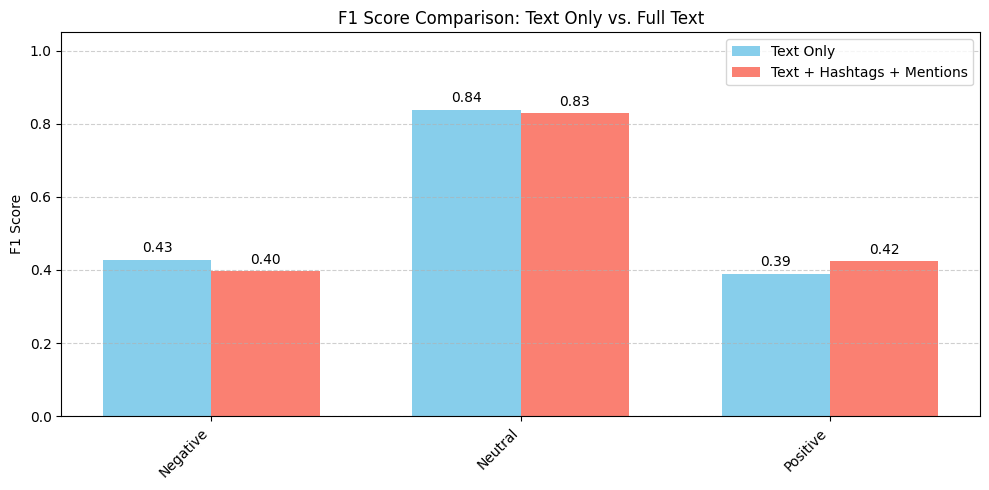

In [17]:
# --- 9. Plot F1 scores ---
f1_text_only = f1_score(y_test, y_pred_text_only, average=None)
f1_text_full = f1_score(y_test, y_pred_text_full, average=None)

x = np.arange(len(sentiment_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, f1_text_only, width, label='Text Only', color='skyblue')
bars2 = ax.bar(x + width/2, f1_text_full, width, label='Text + Hashtags + Mentions', color='salmon')

ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison: Text Only vs. Full Text')
ax.set_xticks(x)
ax.set_xticklabels(sentiment_labels, rotation=45, ha="right")
ax.set_ylim(0, 1.05)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [18]:
# --- 10. Print Label Distributions ---
print("Sentiment label counts in test set:")
print(np.sum(y_test, axis=0))

print("Sentiment label counts in predictions (Text Only):")
print(np.sum(y_pred_text_only, axis=0))

print("Sentiment label counts in predictions (Full Text):")
print(np.sum(y_pred_text_full, axis=0))


Sentiment label counts in test set:
[ 51. 512.  43.]
Sentiment label counts in predictions (Text Only):
[ 47 399  39]
Sentiment label counts in predictions (Full Text):
[ 45 397  37]


In [19]:
# Convert one-hot encoded labels back to class indices
y_true_sentiment = np.argmax(y_test, axis=1)
y_pred_sentiment_text_only = np.argmax(y_pred_text_only, axis=1)
y_pred_sentiment_text_full = np.argmax(y_pred_text_full, axis=1)

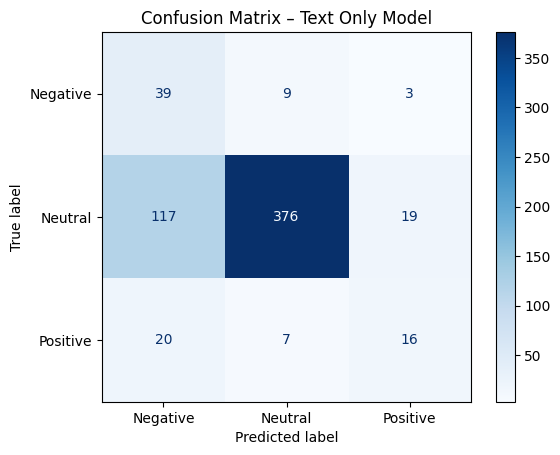

In [20]:
# Text Only Model
cm_text_only = confusion_matrix(y_true_sentiment, y_pred_sentiment_text_only)
disp_text_only = ConfusionMatrixDisplay(confusion_matrix=cm_text_only, display_labels=sentiment_labels)
disp_text_only.plot(cmap="Blues")
plt.title("Confusion Matrix – Text Only Model")
plt.grid(False)
plt.show()

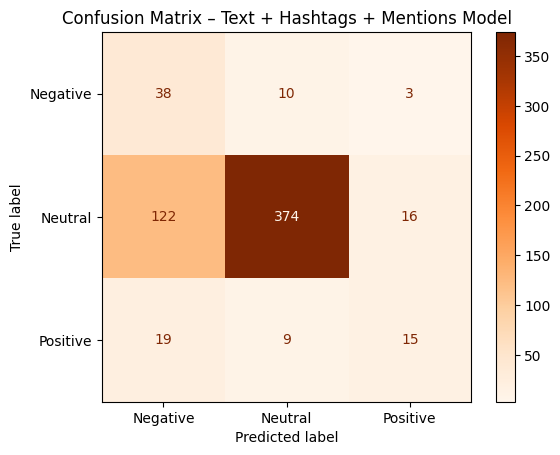

In [21]:
# Full Text Model
cm_text_full = confusion_matrix(y_true_sentiment, y_pred_sentiment_text_full)
disp_text_full = ConfusionMatrixDisplay(confusion_matrix=cm_text_full, display_labels=sentiment_labels)
disp_text_full.plot(cmap="Oranges")
plt.title("Confusion Matrix – Text + Hashtags + Mentions Model")
plt.grid(False)
plt.show()

In [23]:
f1_macro_text_only = f1_score(y_test, y_pred_text_only, average='macro')
print("Macro F1 Score (Logistic Regression):", round(f1_macro_text_only, 3))

Macro F1 Score (Logistic Regression): 0.552


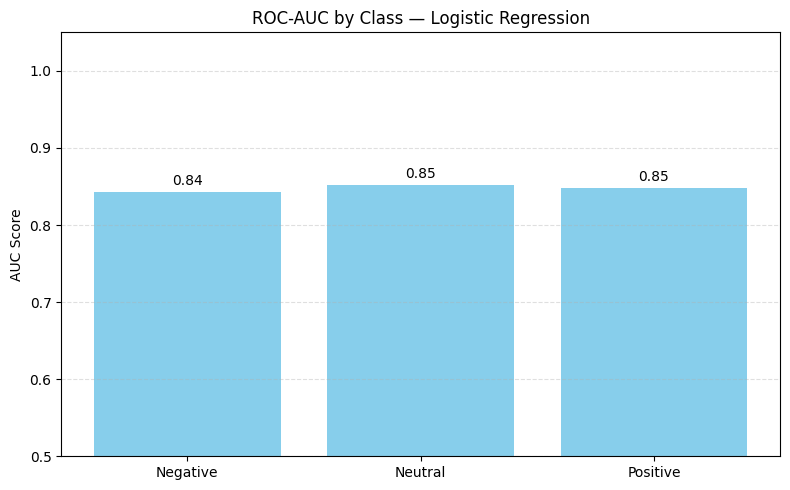

In [24]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities
proba_lr = model_text_only.predict_proba(X_text_only_test_vec)
proba_lr_stacked = np.hstack([cls[:, 1].reshape(-1, 1) for cls in proba_lr])

auc_lr = roc_auc_score(y_test, proba_lr_stacked, average=None, multi_class='ovr')

x = np.arange(len(sentiment_labels))
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x, auc_lr, color='skyblue')

ax.set_title("ROC-AUC by Class — Logistic Regression")
ax.set_ylabel("AUC Score")
ax.set_xticks(x)
ax.set_xticklabels(sentiment_labels)
ax.set_ylim(0.5, 1.05)
ax.bar_label(bars, fmt='%.2f', padding=3)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [22]:
sentiment_labels = sentiment_encoder.categories_[0]
print(sentiment_labels)

['Negative' 'Neutral' 'Positive']



--- Text Only Model Performance ---
              precision    recall  f1-score   support

    Negative       0.75      0.06      0.11        51
     Neutral       0.87      0.98      0.92       512
    Positive       0.50      0.02      0.04        43

   micro avg       0.86      0.84      0.85       606
   macro avg       0.71      0.36      0.36       606
weighted avg       0.83      0.84      0.79       606
 samples avg       0.84      0.84      0.84       606


--- Text + Hashtags + Mentions Model Performance ---
              precision    recall  f1-score   support

    Negative       0.75      0.06      0.11        51
     Neutral       0.87      0.98      0.92       512
    Positive       0.50      0.02      0.04        43

   micro avg       0.86      0.83      0.85       606
   macro avg       0.71      0.35      0.36       606
weighted avg       0.83      0.83      0.79       606
 samples avg       0.83      0.83      0.83       606



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


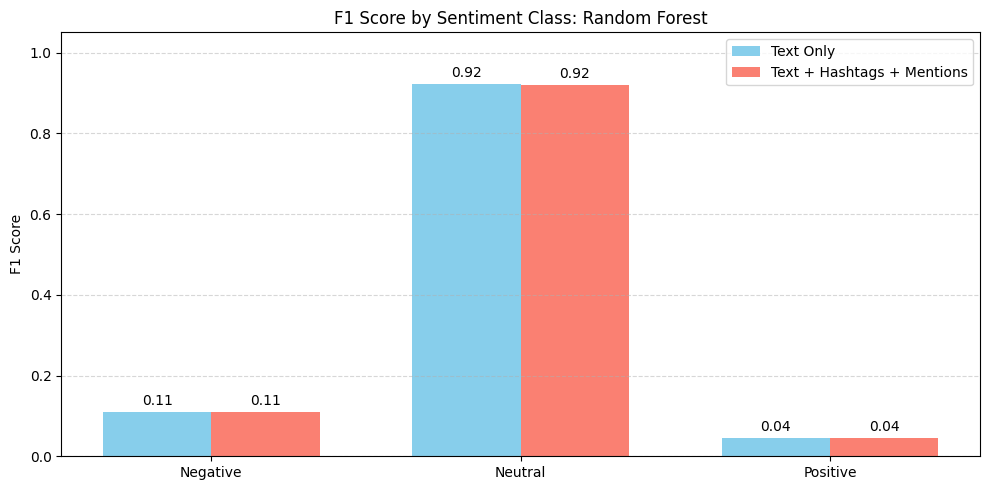

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np

# --- 1. TF-IDF for text_only ---
tfidf_text_only = TfidfVectorizer(max_features=5000, norm='l2')
X_text_only_train_vec = tfidf_text_only.fit_transform(X_text_only_train)
X_text_only_test_vec = tfidf_text_only.transform(X_text_only_test)

# --- 2. TF-IDF for text_full ---
tfidf_text_full = TfidfVectorizer(max_features=5000, norm='l2')
X_text_full_train_vec = tfidf_text_full.fit_transform(X_text_full_train)
X_text_full_test_vec = tfidf_text_full.transform(X_text_full_test)

# --- 3. Oversample (handle class imbalance) ---
ros = RandomOverSampler(random_state=42)

X_text_only_resampled, y_text_only_resampled = ros.fit_resample(X_text_only_train_vec, y_train)
X_text_full_resampled, y_text_full_resampled = ros.fit_resample(X_text_full_train_vec, y_train)

# --- 4. Train Random Forest Models ---
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# text_only
model_text_only = MultiOutputClassifier(rf_classifier)
model_text_only.fit(X_text_only_resampled, y_text_only_resampled)

# text_full
model_text_full = MultiOutputClassifier(rf_classifier)
model_text_full.fit(X_text_full_resampled, y_text_full_resampled)

# --- 5. Predict ---
y_pred_text_only = model_text_only.predict(X_text_only_test_vec)
y_pred_text_full = model_text_full.predict(X_text_full_test_vec)

# --- 6. Evaluate ---
print("\n--- Text Only Model Performance ---")
print(classification_report(y_test, y_pred_text_only, target_names=sentiment_labels))

print("\n--- Text + Hashtags + Mentions Model Performance ---")
print(classification_report(y_test, y_pred_text_full, target_names=sentiment_labels))

# --- 7. F1 Score Comparison Bar Plot ---
f1_text_only = f1_score(y_test, y_pred_text_only, average=None)
f1_text_full = f1_score(y_test, y_pred_text_full, average=None)

x = np.arange(len(sentiment_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, f1_text_only, width, label='Text Only', color='skyblue')
bars2 = ax.bar(x + width/2, f1_text_full, width, label='Text + Hashtags + Mentions', color='salmon')

ax.set_ylabel("F1 Score")
ax.set_title("F1 Score by Sentiment Class: Random Forest")
ax.set_xticks(x)
ax.set_xticklabels(sentiment_labels)
ax.set_ylim(0, 1.05)
ax.legend()
ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [31]:
# Convert one-hot to label indices
y_true = y_test.argmax(axis=1)
y_pred_only = y_pred_text_only.argmax(axis=1)
y_pred_full = y_pred_text_full.argmax(axis=1)

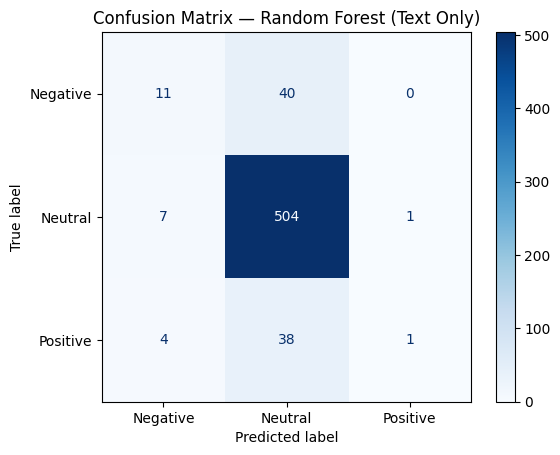

In [32]:
# Compute confusion matrix
cm_only = confusion_matrix(y_true, y_pred_only)

# Display
disp_only = ConfusionMatrixDisplay(confusion_matrix=cm_only, display_labels=sentiment_labels)
disp_only.plot(cmap='Blues')
plt.title("Confusion Matrix — Random Forest (Text Only)")
plt.grid(False)
plt.show()

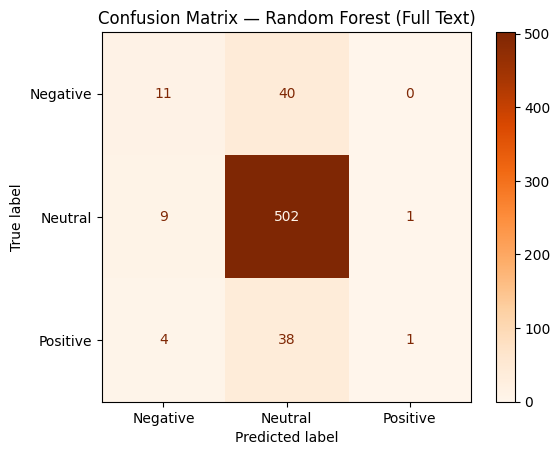

In [33]:
# Compute confusion matrix
cm_full = confusion_matrix(y_true, y_pred_full)

# Display
disp_full = ConfusionMatrixDisplay(confusion_matrix=cm_full, display_labels=sentiment_labels)
disp_full.plot(cmap='Oranges')
plt.title("Confusion Matrix — Random Forest (Full Text)")
plt.grid(False)
plt.show()

In [28]:
f1_macro_text_only = f1_score(y_test, y_pred_text_only, average='macro')
print("Macro F1 Score (Random Forest):", round(f1_macro_text_only, 3))

Macro F1 Score (Random Forest): 0.358


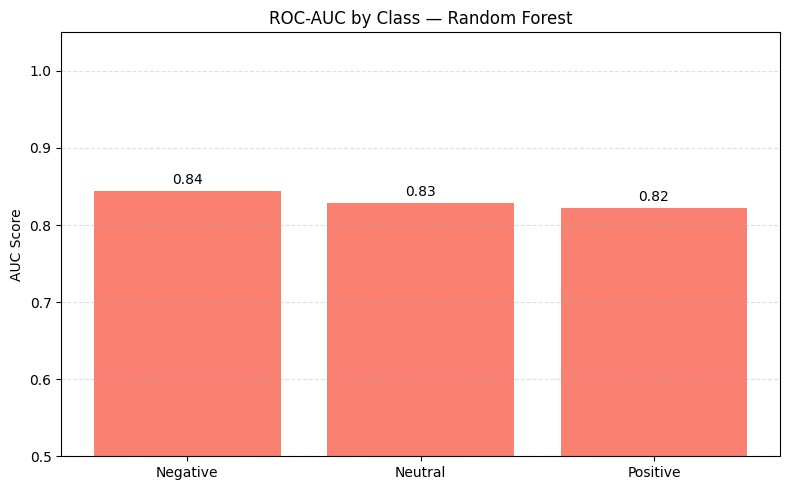

In [29]:
# Get predicted probabilities
proba_rf = model_text_only.predict_proba(X_text_only_test_vec)
proba_rf_stacked = np.hstack([cls[:, 1].reshape(-1, 1) for cls in proba_rf])

auc_rf = roc_auc_score(y_test, proba_rf_stacked, average=None, multi_class='ovr')

x = np.arange(len(sentiment_labels))
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x, auc_rf, color='salmon')

ax.set_title("ROC-AUC by Class — Random Forest")
ax.set_ylabel("AUC Score")
ax.set_xticks(x)
ax.set_xticklabels(sentiment_labels)
ax.set_ylim(0.5, 1.05)
ax.bar_label(bars, fmt='%.2f', padding=3)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()